# Train a new language model from scratch
Based on two notebook:
- Huggingface Train Model from Scratch: https://huggingface.co/blog/how-to-train
- Chris McCormick: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

Train our language model using the [`run_language_modeling.py`](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py) script from `transformers`.Just remember to leave `--model_name_or_path` to `None` to train from scratch vs. from an existing model or checkpoint.

## Setup

Huggingface recommended training a byte-level BPE (rather than let’s say, a WordPiece tokenizer like BERT) because it will start building its vocabulary from an alphabet of single bytes, so all words will be decomposable into tokens (no more `<unk>` tokens!).

But this does not seems to work well with Khmer unicode. It encoded gibberish characters. So I'm using WorkPiece tokenizer instead.


In [0]:
# Install dependencies
#!pip uninstall -y tensorflow
!pip install transformers

     |████████████████████████████████| 573kB 433kB/s 
     |████████████████████████████████| 3.7MB 57.0MB/s 
     |████████████████████████████████| 870kB 51.3MB/s 
     |████████████████████████████████| 1.0MB 57.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=a25f9d2c1920e1c315be0408fbe07fc4bfd3494210caa916f5d22a4a38d307f3
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
# Get the example scripts.
!wget -c https://raw.githubusercontent.com/huggingface/transformers/master/examples/run_language_modeling.py

--2020-04-06 16:43:00--  https://raw.githubusercontent.com/huggingface/transformers/master/examples/run_language_modeling.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34328 (34K) [text/plain]
Saving to: ‘run_language_modeling.py’

run_language_modeli 100%[===================>]  33.52K  --.-KB/s    in 0.08s   

2020-04-06 16:43:01 (430 KB/s) - ‘run_language_modeling.py’ saved [34328/34328]



In [0]:
# Check that we have a GPU
!nvidia-smi

Mon Apr  6 16:43:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Check that PyTorch sees it
import torch
print("cuda avail:", torch.cuda.is_available())
print("id:", torch.cuda.get_device_name(0))

cuda avail: True
id: Tesla P100-PCIE-16GB


## Get Khmer Data
These data must be segmented already. I have github files from my previous project here:
https://github.com/phylypo/segmentation-crf-khmer/

In [0]:
sizes = ["100","500","1000","5000","10000"]
# Select available size (0-4) that you want to use
docsize = sizes[2] # 10K data gave lower accuracy 59% vs 91% with 1K -- why?
data_dir = "kh_data_" + docsize
file_name = data_dir + ".zip" # need old file format with space

In [0]:
# Download the file from `url` and save it
import urllib.request
base_url = "https://github.com/phylypo/segmentation-crf-khmer/raw/master/data/"
url = base_url + file_name
print("Downloading from:", url)
urllib.request.urlretrieve(url, file_name)

('kh_data_1000.zip', <http.client.HTTPMessage at 0x7f01c93fee48>)

In [0]:
# remove previous existing directory for rerun
!rm -rf {data_dir}
print("- Unzipping the file and show last few extracted files:")
!unzip {file_name} | tail -10

print("- Count the number of files:")
!ls -al {data_dir}/*_seg*.txt | wc -l

- Unzipping the file and show last few extracted files:
  inflating: kh_data_1000/313546_seg.txt  
  inflating: kh_data_1000/313565_orig.txt  
  inflating: kh_data_1000/313565_seg.txt  
  inflating: kh_data_1000/313575_orig.txt  
  inflating: kh_data_1000/313575_seg.txt  
  inflating: kh_data_1000/313576_orig.txt  
  inflating: kh_data_1000/313576_seg.txt  
  inflating: kh_data_1000/313577_orig.txt  
  inflating: kh_data_1000/313577_seg.txt  
  inflating: kh_data_1000/meta.txt   
- Count the number of files:
1000


In [0]:
!head -1 kh_data_1000/313546_seg.txt

 លោកស្រី សុផុន ប្រធាន ធម្មការ ស្រុក ស្រី ស្នំ ឃុបឃិត ជាមួយ  មេឃុំ  មេភូមិ  លក់ ដី សហគម ន៏  ជិង ២០០ ហិកតា


## Tokenizer

In [0]:
%%time 
from pathlib import Path
from tokenizers import ByteLevelBPETokenizer, BertWordPieceTokenizer

paths = [str(x) for x in Path(data_dir).glob("*_seg.txt")]
print("Datadir:", data_dir)

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()
# Customize training
tokenizer.train(files=paths, vocab_size=52_000, min_frequency=2, 
                special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "[UNK]",
    "<mask>",
    "[SEP]",
    "[CLS]",
])

# this need token: [SEP], [CLS], unk, mask
tokenizer_bert = BertWordPieceTokenizer(strip_accents=False, lowercase=False, \
                                        handle_chinese_chars=False, clean_text=False)
tokenizer_bert.train(files=paths, vocab_size=52_000, min_frequency=2, 
                special_tokens=['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]' ])


Datadir: kh_data_1000
CPU times: user 3.53 s, sys: 183 ms, total: 3.71 s
Wall time: 2.23 s


Now let's save files to disk

In [0]:
!rm -rf BERT
!mkdir BERT
tokenizer_bert.save("BERT")
#BertWordPieceTokenizer only have: vocab.txt

['BERT/vocab.txt']

In [0]:
!ls -lh BERT/vocab.txt
!wc BERT/vocab.txt #10K: 52,000 vocab size, 1K: 15713 
!tail -10 BERT/vocab.txt

-rw-r--r-- 1 root root 237K Apr  6 17:32 BERT/vocab.txt
 15713  15713 241772 BERT/vocab.txt
Elizabeth
HYUNDAI
Hamamatsu
INDUSTRIAL
Surprise
Sakoltee
Tomahawk
cambodiawikinewsSharing
យេរ៉ូសាឡឹម
##642333


### Load BERT Tokenizer

In [0]:
from tokenizers.implementations import BertWordPieceTokenizer

#tokenizer_bert = BertWordPieceTokenizer("./BERT/vocab.txt",strip_accents=False)
tokenizer_bert = BertWordPieceTokenizer("./BERT/vocab.txt",strip_accents=False, lowercase=False, \
                                        handle_chinese_chars=False, clean_text=False)

In [0]:
# bytLevleBPETokenizer has bad encoding, BertWordPiece is ok when add tokenize_chinese_chars
tokenizer_bert.encode("ឃាត់ ជនសង្ស័យ ម្នាក់ បន្ទាប់ពី ").tokens
#['[CLS]', 'ឃាត់', 'ជនសង្ស័យ', 'ម្នាក់', 'បន្ទាប់ពី', '[SEP]']

['[CLS]', 'ឃាត់', 'ជនសង្ស័យ', 'ម្នាក់', 'បន្ទាប់ពី', '[SEP]']

In [0]:
#tokenizer_bert.encode("បន្ទាប់មក ជនរងគ្រោះ ខាងលើ  ក៏ ឆែកមើល").tokens
#['[CLS]', 'បន្ទាប់', '##មក', 'ជនរងគ្រោះ', 'ខាងលើ', 'ក៏', 'ឆែកមើល', '[SEP]']

tokenizer_bert.encode("លួច យក.").tokens

['[CLS]', 'លួច', 'យក', '.', '[SEP]']

## Train a language model


### Setup BERT Config and run pre-train

In [0]:
# can't seems to too many files, so combine to one file
#!cat kh_data_10000/*_seg.txt > train_text.txt 
!cat kh_data_1000/*_seg.txt > train_text.txt 
!ls -alh train_text.txt

-rw-r--r-- 1 root root 4.7M Apr  6 17:34 train_text.txt


In [0]:
!du -sh kh_data_1000
#!du -sh kh_data_10000
!wc train_text.txt #10K: 87874  3,368,883 words, 1K:9256 lines, 334,469 words

14M	kh_data_1000
   9256  334469 4910523 train_text.txt


In [0]:
## Each architecture is provided with several class for fine-tuning on down-stream tasks, e.g.
# BERT_MODEL_CLASSES = [BertModel, BertForPreTraining, BertForMaskedLM, BertForNextSentencePrediction,
#                       BertForSequenceClassification, BertForTokenClassification, BertForQuestionAnswering]

import json
config = {
	"architectures": [
		"BertForMaskedLM"
	],
	"attention_probs_dropout_prob": 0.1,
	"hidden_act": "gelu",
	"hidden_dropout_prob": 0.1,
	"hidden_size": 768,
	"initializer_range": 0.02,
	"intermediate_size": 3072,
	"layer_norm_eps": 1e-05,
	"max_position_embeddings": 514,
	"model_type": "bert",
	"num_attention_heads": 12,
	"num_hidden_layers": 6,
	"type_vocab_size": 1,
	"vocab_size": 52000,
	"vocab_file": "BERT/vocab.txt"
}
with open("./BERT/config.json", 'w') as fp:
    json.dump(config, fp)

tokenizer_config = {
	"max_len": 512
}
with open("./BERT/tokenizer_config.json", 'w') as fp:
    json.dump(tokenizer_config, fp)

In [0]:
!rm -rf Bert-small-v1 
!mkdir Bert-small-v1

# clear out gpu memory if need to rerun
torch.cuda.empty_cache()

In [0]:
#args.model_type in ["bert", "roberta", "distilbert", "camembert"] 
cmd =	"""
  python run_language_modeling.py
  --train_data_file ./train_text.txt
  --output_dir ./Bert-small-v1
	--model_type bert
	--mlm
	--config_name ./BERT
	--tokenizer_name ./BERT
	--do_train
	--line_by_line
	--learning_rate 1e-4
	--num_train_epochs 1
	--save_total_limit 2
	--save_steps 2000
	--per_gpu_train_batch_size 4
	--seed 42
	--cache_dir BERT
""".replace("\n", " ")

# This warning is ok
#Model name './BERT' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, 
#bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, 
#bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, 
#bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, 
#bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased, bert-base-finnish-cased-v1, 
#bert-base-finnish-uncased-v1, bert-base-dutch-cased). 
#Assuming './BERT' is a path, a model identifier, or url to a directory containing tokenizer files.

In [0]:
%%time
print("cmd:", cmd)
!{cmd}
#1k data took 2:30 sec

cmd:    python run_language_modeling.py   --train_data_file ./train_text.txt   --output_dir ./Bert-small-v1 	--model_type bert 	--mlm 	--config_name ./BERT 	--tokenizer_name ./BERT 	--do_train 	--line_by_line 	--learning_rate 1e-4 	--num_train_epochs 1 	--save_total_limit 2 	--save_steps 2000 	--per_gpu_train_batch_size 4 	--seed 42 	--cache_dir BERT 
04/06/2020 17:39:39 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
04/06/2020 17:39:39 - INFO - transformers.configuration_utils -   loading configuration file ./BERT/config.json
04/06/2020 17:39:39 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_ac

In [0]:
!du -sh BERT
!du -sh Bert-small-v1/*

700K	BERT
959M	Bert-small-v1/checkpoint-18000
959M	Bert-small-v1/checkpoint-20000
4.0K	Bert-small-v1/config.json
321M	Bert-small-v1/pytorch_model.bin
4.0K	Bert-small-v1/special_tokens_map.json
4.0K	Bert-small-v1/tokenizer_config.json
4.0K	Bert-small-v1/training_args.bin
688K	Bert-small-v1/vocab.txt


# Finetune for classification
Train for Khmer article classification for traffic accident related

## Get training Data

### Copy accident data file from github

In [0]:
filename = 'accident_docs.pkl';

In [2]:
import urllib.request
url = 'https://github.com/phylypo/khmer-text-data/blob/master/classifications/accident_docs.pkl?raw=true'
print("url", url)
urllib.request.urlretrieve(url, filename)

url https://github.com/phylypo/khmer-text-data/blob/master/classifications/accident_docs.pkl?raw=true


('accident_docs.pkl', <http.client.HTTPMessage at 0x7f2ebc2627f0>)

In [4]:
import pandas as pd
df2 = pd.read_pickle(filename);
df2

,<built-in function id>,text,cat
0,7452,ដោយសារតែ បើកបរ លឿន ជិត ៗ គ្នា ពេក រថយន្ត ៦ គ្...,accident
1,7513,រថយន្ត តារា កំប្លែង ជើង ចាស់ នាយ កុយ បែក កង់...,accident
2,7516,ជនជាតិ យូក្រែន ម្នាក់ ក្រឡាប់ រថយន្ត នៅ ស្រុក...,accident
3,7667,ខ្លាំង ម្ល៉េះ ! គេ ជួយ ប្រាប់ ខ្លាច បង្ក គ្រោ...,None
4,7713,លិខិត មិត្ត អ្នកអាន៖ « នយោបាយ ក្តិច ត្រួយ ជា ...,None
...,...,...,...
815,695507,សូម បងប្អូន ជួយ ស៊ែរ បន្ត ផង ... ប្អូន ស្រី ម្...,
816,695704,តួកគី ដាក់ពង្រាយ ប៉ូលិស ១ ពាន់ នាក់ នៅ តាម ព...,
817,697836,វាយប្រហារ ភេរវកម្ម នៅ អាហ្វហ្គានីស្ថាន ស្លាប់...,
818,699060,ព័ត៌មាន ថ្មី ៗ COVID-19: ចំនួន អ្នកស្លាប់ ដោយ...,


In [6]:
import numpy as np
df2['label'] = np.where(df2['cat'] == 'accident', 1, 0)
df = df2
df

,<built-in function id>,text,cat,label
0,7452,ដោយសារតែ បើកបរ លឿន ជិត ៗ គ្នា ពេក រថយន្ត ៦ គ្...,accident,1
1,7513,រថយន្ត តារា កំប្លែង ជើង ចាស់ នាយ កុយ បែក កង់...,accident,1
2,7516,ជនជាតិ យូក្រែន ម្នាក់ ក្រឡាប់ រថយន្ត នៅ ស្រុក...,accident,1
3,7667,ខ្លាំង ម្ល៉េះ ! គេ ជួយ ប្រាប់ ខ្លាច បង្ក គ្រោ...,None,0
4,7713,លិខិត មិត្ត អ្នកអាន៖ « នយោបាយ ក្តិច ត្រួយ ជា ...,None,0
...,...,...,...,...
815,695507,សូម បងប្អូន ជួយ ស៊ែរ បន្ត ផង ... ប្អូន ស្រី ម្...,,0
816,695704,តួកគី ដាក់ពង្រាយ ប៉ូលិស ១ ពាន់ នាក់ នៅ តាម ព...,,0
817,697836,វាយប្រហារ ភេរវកម្ម នៅ អាហ្វហ្គានីស្ថាន ស្លាប់...,,0
818,699060,ព័ត៌មាន ថ្មី ៗ COVID-19: ចំនួន អ្នកស្លាប់ ដោយ...,,0


In [8]:
# Get the lists of sentences and their labels.
sentences = df.text.values
labels = df.label.values
print("len sen:", len(sentences))
print("len labels:", len(labels))

len sen: 820
len labels: 820


## Tokenize dataset

In [0]:
# need to be BertTokenizer
#from tokenizers.implementations import BertWordPieceTokenizer
#tokenizer = BertWordPieceTokenizer("./BERT/vocab.txt",strip_accents=False, lowercase=False, \
#                                        handle_chinese_chars=False, clean_text=False)
from transformers import pipeline, BertTokenizer
MODEL_PATH = "./Bert-small-v1/"
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH, do_lower_case=False)

In [0]:
max_len = 0

# For every sentence...
wlens = []
idslens = []
for sent in sentences:
    wlens.append(len(sent.split()))
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    idslens.append(min(len(input_ids), 512))
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

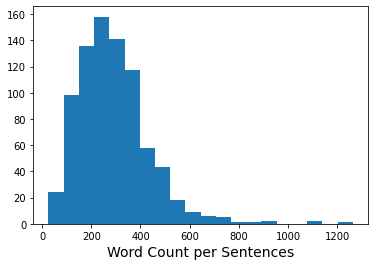

In [0]:
# graph length of input_ids
import matplotlib.pyplot as plt
#plt.bar(len(input_ids))
#plt.bar(df["date"], df["count"])
plt.hist(wlens, bins=20)
plt.xlabel(u'Word Count per Sentences',fontsize=14)
plt.show()

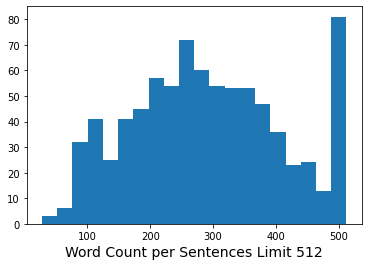

In [0]:
plt.hist(idslens, bins=20)
plt.xlabel(u'Word Count per Sentences Limit 512',fontsize=14)
plt.show()

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
MAX_LEN = 512
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,      # 64 Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  ដោយសារតែ បើកបរ លឿន ជិត ៗ គ្នា ពេក  រថយន្ត ៦ គ្រឿង  បាន បុក គូថ បន្ត គ្នា  នៅលើ ផ្លូវ ជាតិ លេខ ៥  កំពង់ឆ្នាំង  ៖  រថយន្ត ចំនួន ៦ គ្រឿង  បាន រង ការខូចខាត ធ្ងន់  និង ស្រាល  ដោយសារ បើក លឿន ជិត ៗ គ្នា ពេក  ក៏ បុក គូថ បន្ត កន្ទុយ គ្នា លើ ផ្លូវ ជាតិ លេខ ៥  ខណៈ ដែល រថយន្ត ខាងមុខ គេ បាន  ជួប នឹង ឧបសគ្គ  បាន ជាន់ ហ្វ្រាំង ឈប់ ដោយ បង្ខំ ។ ហេតុការណ៍ គ្រោះថ្នាក់ ចរាចរណ៍ នេះ  បាន កើតឡើង នៅ វេលា ម៉ោង ១០ និង ៣០ នាទី ព្រឹក  ថ្ងៃទី ១៩  ខែមករា  ឆ្នាំ ២០១៩  លើ ផ្លូវ ជាតិ លេខ ៥  ចំណុច ភូមិ ស្ពករាជ្យ  ឃុំ អណ្ដូង ស្នាយ  ស្រុក រលាប្អៀរ  ប៉ុន្តែ នៅក្នុង ហេតុការណ៍ គ្រោះថ្នាក់ នេះ  មិន មាន អ្នកណា រងរបួស ឡើយ  គឺ ខូចខាត រថយន្ត ស្រាល  និង ធ្ងន់ តែ ប៉ុណ្ណោះ ។  សមត្ថកិច្ច នគរបាល ចរាចរណ៍ ស្រុក រលាប្អៀរ នៅ កន្លែង កើត ហេតុ បាន និយាយ ឲ្យដឹង ថា  រថយន្ត អាច ច្រើន ជាង ៦ គ្រឿង  ដែល ជួប នឹង គ្រោះថ្នាក់ ចរាចរណ៍ ដោយ បាន បុក បន្ត កន្ទុយ គ្នា  ហើយ រថយន្ត ខ្លះ  ក្រោយ កើត ហេតុ  ដោយ រង ការខូចខាត តិចតួច  ក៏ បាន ចាកចេញ  ពី កន្លែង កើត ហេតុ  មុនពេល សមត្ថកិច្ច នគរបាល មកដល់  ពិសេស រថយន្ត ដែល មិន ស្គាល់ ម៉ាក នៅមុខ គេ បង្អស់ ជា អ

In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  738 training samples
   82 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Train Our Classification Model

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

MODEL_PATH = "./Bert-small-v1/"

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    MODEL_PATH, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(15713, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, element

In [0]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 105 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (52000, 768)
bert.embeddings.position_embeddings.weight                (514, 768)
bert.embeddings.token_type_embeddings.weight                (1, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 20 #4 #start with 4 first, then 20

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
#!pip install tensorflow

In [0]:
#dont need this
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [0]:
import torch
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


We're ready to kick off the training!

In [0]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.70
  Training epcoh took: 0:00:19

Running Validation...
  Accuracy: 0.48
  Validation Loss: 0.70
  Validation took: 0:00:01

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.70
  Training epcoh took: 0:00:19

Running Validation...
  Accuracy: 0.48
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.71
  Training epcoh took: 0:00:19

Running Validation...
  Accuracy: 0.52
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.71
  Training epcoh took: 0:00:19

Running Validation...
  Accuracy: 0.52
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.69
  Training epcoh took: 0:00:19

Running Validation...
  Accuracy: 0.48
  Validation Loss: 0.69
  Validation took: 0:00:01

======== Epoch

Let's view the summary of the training process.

In [0]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.70,7.02e-01,0.48,0:00:19,0:00:01
2,0.70,6.94e-01,0.48,0:00:19,0:00:01
3,0.71,6.93e-01,0.52,0:00:19,0:00:01
4,0.71,6.92e-01,0.52,0:00:19,0:00:01
5,0.69,6.92e-01,0.48,0:00:19,0:00:01
6,0.67,6.21e-01,0.69,0:00:19,0:00:01
7,0.37,2.37e-01,0.94,0:00:19,0:00:01
8,0.21,1.15e-01,0.97,0:00:19,0:00:01
9,0.14,3.97e-02,0.99,0:00:19,0:00:01


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

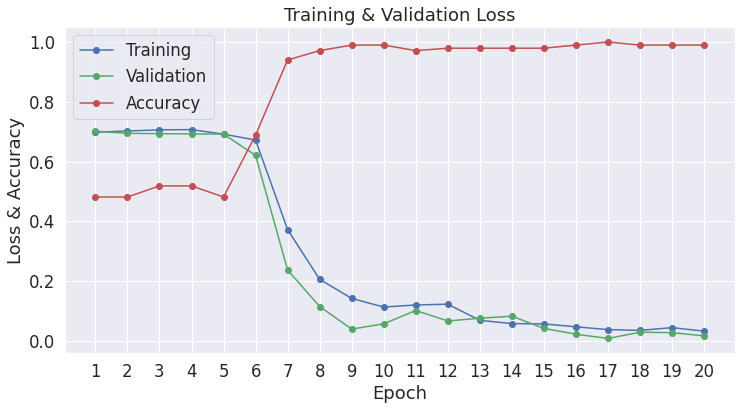

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Accuracy")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss & Accuracy")
plt.legend()
col_range = range(1,21)
plt.xticks(col_range)

plt.show()